URL

https://www.nature.com/articles/s41586-019-1631-3

In [1]:
import os
from pathlib import Path
import anndata
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gseapy as gp
from scipy.stats import ttest_ind, ranksums
from statsmodels.stats.multitest import multipletests

from src.gene_sets import SncGeneSets
from src.utils import pqvals
from src.plotter import savefig

In [ ]:
root = Path('figures/Supplement/chunks')
root.mkdir(exist_ok=True)

In [5]:
path = Path(os.path.expanduser("~/data/CompBio/GSE136103-Liver_Cirrhosis"))
files = list(path.iterdir())
files = [str(f).rsplit('_', 1)[0] + "_" for f in files]
files = [Path(f) for f in set(files)]

adata_list = {
    path.stem: sc.read_10x_mtx(path.parent, prefix=path.stem) for path in files
}

In [6]:
for f, adata in adata_list.items():
    sample = str(Path(f).stem).split('_', 1)[0]
    if 'healthy' in f:
        adata.obs['condition'] = 'healthy'
    else:
        adata.obs['condition'] = 'cirrhotic'
    adata.obs['sample'] = sample

adata = anndata.concat(list(adata_list.values()))
adata.obs_names_make_unique()

/Users/euxhenh/micromamba/envs/ml12/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [8]:
sc.pp.filter_genes(adata, min_cells=50)
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.log1p(adata)

In [9]:
adata

AnnData object with n_obs × n_vars = 24884 × 17448
    obs: 'condition', 'sample', 'n_genes'
    var: 'n_cells'
    uns: 'log1p'

In [9]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

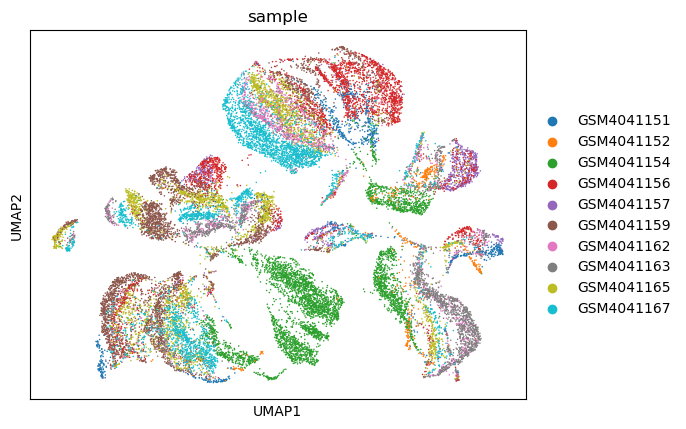

In [10]:
sc.pl.umap(adata, color='sample')

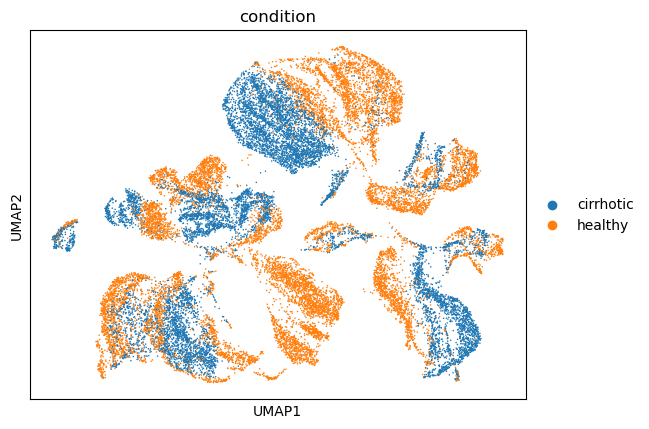

In [11]:
sc.pl.umap(adata, color='condition')

In [10]:
cir_adata = adata[adata.obs['condition'] == 'cirrhotic']
healthy_adata = adata[adata.obs['condition'] == 'healthy']

In [11]:
cir_mean = np.asarray(cir_adata.X.mean(0)).ravel()
healthy_mean = np.asarray(healthy_adata.X.mean(0)).ravel()
log2fc = cir_mean - healthy_mean

In [12]:
rank_df = pd.DataFrame(index=adata.var_names, data=log2fc, columns=['log2fc'])
rank_df.sort_values('log2fc', inplace=True, ascending=False)

In [ ]:
SNC = SncGeneSets(SenSet="resources/SenSet.txt")
gene_sets = {
    'GO': SNC.GO,
    'Fridman': SNC.Fridman,
    'SenMayo': SNC.SenMayo,
    'CellAge': SNC.CellAge,
    'SenSet': SNC.SenSet,
}

In [18]:
res = gp.prerank(
    rank_df,
    gene_sets=gene_sets,
)

2025-08-02 21:19:04,556 [WARNING] Duplicated values found in preranked stats: 0.61% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


In [19]:
df = res.res2d
df['-log10(FDR)'] = -np.log10(df['FDR q-val'].to_numpy().astype(float))
df['-log10(FWER)'] = -np.log10(df['FWER p-val'].to_numpy().astype(float))

/var/folders/b_/1w737bbn611fq7bhjvy_zm240000gn/T/ipykernel_31775/425373384.py:2: RuntimeWarning: divide by zero encountered in log10
  df['-log10(FDR)'] = -np.log10(df['FDR q-val'].to_numpy().astype(float))
/var/folders/b_/1w737bbn611fq7bhjvy_zm240000gn/T/ipykernel_31775/425373384.py:3: RuntimeWarning: divide by zero encountered in log10
  df['-log10(FWER)'] = -np.log10(df['FWER p-val'].to_numpy().astype(float))


Text(0.5, 1.0, 'Liver Cirrhosis')

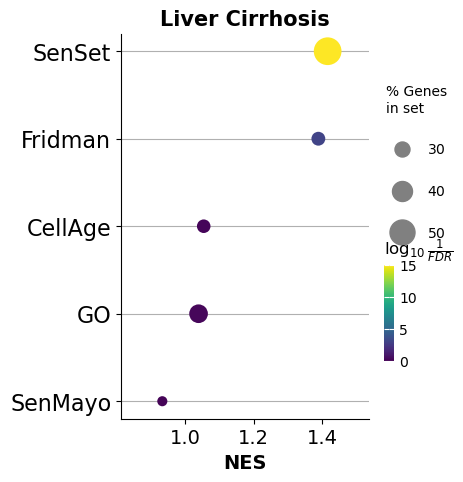

In [ ]:
ax = gp.dotplot(
    res.res2d,
    column="FDR q-val",
    title='',
    cmap=plt.cm.viridis,
    size=6,
    figsize=(4, 5),
    cutoff=1,
    show_ring=False,
)
sns.despine(ax=ax)
ax.set_title('Liver Cirrhosis', fontsize=15, fontweight=700)

savefig(root / 'Liver-Cirrhosis-Dotplot-FDR.pdf')

In [39]:
res.res2d.to_csv('results/Liver-Cirrhosis.csv')